# Conditional Generative Pretrained Transformer (GPT)

This notebook demonstrates generation of molecules using a GPT model conditioned on $logP$ and SAS values

## Setting up the notebook and importing necessary libraries

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import QED, Descriptors
from rdkit.Chem import RDConfig
from rdkit import RDLogger
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer
import re
import math
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

lg = RDLogger.logger()
lg.setLevel(RDLogger.ERROR)
RDLogger.DisableLog('rdApp.*')

## Load dataset, tokenize SMILES and make PyTorch `Dataloaders`

In [2]:
# Dataset class
class ZincDataset(Dataset):
    def __init__(self, data, block_size):
        self.data = data
        self.max_len = block_size
        self.pattern = re.compile(r"(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])")
        
        # Build vocabulary from all SMILES in dataset
        all_tokens = set()
        for smiles in data['smiles']:
            tokens = self.pattern.findall(smiles)
            all_tokens.update(tokens)
        all_tokens.add('<')  # Padding token
        self.vocab = sorted(list(all_tokens))
        self.stoi = {ch:i for i,ch in enumerate(self.vocab)}
        self.itos = {i:ch for i,ch in enumerate(self.vocab)}
        self.vocab_size = len(self.vocab)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        smiles = self.data.iloc[idx]['smiles'].strip()
        logp = self.data.iloc[idx]['logP']
        sas = self.data.iloc[idx]['SAS']
        
        # Tokenize SMILES
        tokens = self.pattern.findall(smiles)
        tokens += ['<'] * (self.max_len - len(tokens))
        if len(tokens) > self.max_len:
            tokens = tokens[:self.max_len]
        
        try:
            dix = [self.stoi[s] for s in tokens]
        except KeyError as e:
            print(f"Error tokenizing: {smiles}")
            print(f"Problem token: {e}")
            raise
        
        x = torch.tensor(dix[:-1], dtype=torch.long)
        y = torch.tensor(dix[1:], dtype=torch.long)
        props = torch.tensor([logp, sas], dtype=torch.float)
        
        return x, y, props
    
def load_data(file_path):
    data = pd.read_csv(file_path)
    pattern = re.compile(r"(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\|\/|:|~|@|\?|>>?|\*|\$|\%[0-9]{2}|[0-9])")
    lens = [len(pattern.findall(s)) for s in data['smiles']]
    max_len = max(lens)
    return data, max_len

In [3]:
data, max_len = load_data('../../datasets/zinc250k.csv')
dataset = ZincDataset(data, block_size=max_len)

## Defining Elements of the model architecture

### Self-Attention and Transformer Blocks

*Causal Self Attention* which is a form of Masked Self Attention is used where only the tokens from the past until the present are used to predict the next token. Each block is a unit of the Conditional GPT model which is repeated several times in the architecture.

In [4]:
class CausalSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        self.key = nn.Linear(config.n_embd, config.n_embd)
        self.query = nn.Linear(config.n_embd, config.n_embd)
        self.value = nn.Linear(config.n_embd, config.n_embd)
        self.attn_drop = nn.Dropout(config.attn_pdrop)
        self.resid_drop = nn.Dropout(config.resid_pdrop)
        self.proj = nn.Linear(config.n_embd, config.n_embd)
        self.n_head = config.n_head
        
        # Causal mask with space for property embeddings
        self.register_buffer("mask", torch.tril(torch.ones(config.block_size + 1, config.block_size + 1))
                             .view(1, 1, config.block_size + 1, config.block_size + 1))
    
    def forward(self, x):
        B, T, C = x.size()
        k = self.key(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        q = self.query(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = self.value(x).view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.mask[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_drop(att)
        y = att @ v
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_drop(self.proj(y))
        return y

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln1 = nn.LayerNorm(config.n_embd)
        self.ln2 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.resid_pdrop),
        )
    
    def forward(self, x):
        x = x + self.attn(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x

### Defining the GPT model

In [5]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.tok_emb = nn.Embedding(config.vocab_size, config.n_embd)
        self.pos_emb = nn.Parameter(torch.zeros(1, config.block_size, config.n_embd))
        self.drop = nn.Dropout(config.embd_pdrop)
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        self.prop_nn = nn.Linear(2, config.n_embd)  # For logP and SAS
        
        self.apply(self._init_weights)
        print("number of parameters:", sum(p.numel() for p in self.parameters()))
    
    def _init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
    
    def get_block_size(self):
        return self.config.block_size
    
    def forward(self, idx, targets=None, prop=None):
        b, t = idx.size()
        assert t <= self.config.block_size, "Cannot forward, model block size is exhausted."
        
        token_embeddings = self.tok_emb(idx)
        position_embeddings = self.pos_emb[:, :t, :]
        x = self.drop(token_embeddings + position_embeddings)
        
        if prop is not None:
            p = self.prop_nn(prop.unsqueeze(1))
            x = torch.cat([p, x], 1)
        
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.head(x)
        
        if prop is not None:
            logits = logits[:, 1:, :]
        
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.view(-1))
        
        return logits, loss

## Training the model

In [12]:
losses = []

def train(model, dataset, batch_size=128, epochs=10, lr=3e-4):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        pbar = tqdm(enumerate(loader), total=len(loader))
        for it, (x, y, props) in pbar:
            x = x.to('cuda')
            y = y.to('cuda')
            props = props.to('cuda')
            
            logits, loss = model(x, y, props)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
            
            pbar.set_description(f"epoch {epoch+1} iter {it}: loss {loss.item():.5f}")

#### Defining the Config file for the model

In [13]:
class GPTConfig:
    def __init__(self, vocab_size, block_size, **kwargs):
        self.vocab_size = vocab_size
        self.block_size = block_size
        self.embd_pdrop = 0.1
        self.resid_pdrop = 0.1
        self.attn_pdrop = 0.1
        self.n_layer = 8
        self.n_head = 8
        self.n_embd = 256
        for k,v in kwargs.items():
            setattr(self, k, v)

In [14]:

config = GPTConfig(dataset.vocab_size, max_len, num_props=2)
model = GPT(config).to('cuda')

train(model, dataset, batch_size=128, epochs=10)


number of parameters: 6370048


epoch 10 iter 1948: loss 0.28203: 100%|██████████| 1949/1949 [02:20<00:00, 13.83it/s]


## Plot loss curves

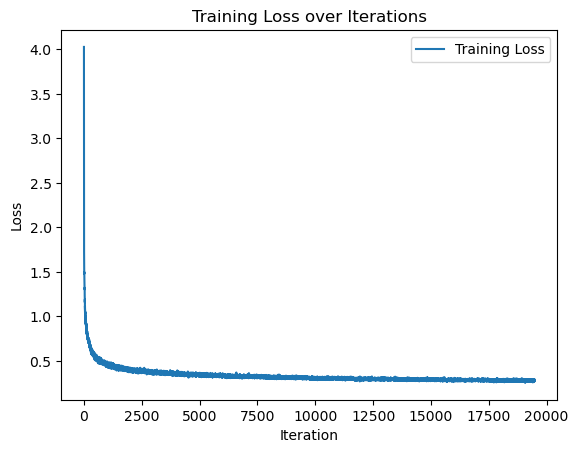

In [15]:
plt.plot(losses, label='Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss over Iterations')
plt.legend()
plt.show()

## Generating molecules

In [9]:
def sample(model, x, steps, temperature=1.0, sample=True, top_k=None, prop=None):
    block_size = model.get_block_size()
    model.eval()
    
    with torch.no_grad():
        for k in range(steps):
            x_cond = x if x.size(1) <= block_size else x[:, -block_size:]
            logits, _ = model(x_cond, prop=prop)
            logits = logits[:, -1, :] / temperature
            if top_k is not None:
                v, ix = torch.topk(logits, top_k)
                logits[logits < v[:, [-1]]] = -float('Inf')
            probs = F.softmax(logits, dim=-1)
            if sample:
                ix = torch.multinomial(probs, num_samples=1)
            else:
                _, ix = torch.topk(probs, k=1, dim=-1)
            x = torch.cat((x, ix), dim=1)
    
    return x

In [10]:
# defining property ranges
logp_range = (data['logP'].min(), data['logP'].max())
sas_range = (data['SAS'].min(), data['SAS'].max())

#number of target conditions and number of generations per condition
num_conditions = 100
num_samples_per_condition = 10

generated_smiles = []
generated_targets = []

for _ in range(num_conditions):
    target_logp = np.random.uniform(*logp_range)
    target_sas = np.random.uniform(*sas_range)
    
    print(f"\nGenerating {num_samples_per_condition} molecules with logP={target_logp:.2f}, SAS={target_sas:.2f}")
    
    for _ in range(num_samples_per_condition):
        # Use context token if needed
        context = "C"  # or "" if not needed
        x = torch.tensor([dataset.stoi[s] for s in dataset.pattern.findall(context)], dtype=torch.long)[None,...].to('cuda')
        props = torch.tensor([target_logp, target_sas], dtype=torch.float)[None,...].to('cuda')
        
        y = sample(model, x, steps=100, temperature=1.0, prop=props)
        completion = ''.join([dataset.itos[int(i)] for i in y[0]]).replace('<', '')
        
        generated_smiles.append(completion)
        generated_targets.append((target_logp, target_sas))

print(f"\nGenerated {len(generated_smiles)} molecules.")


Generating 10 molecules with logP=-1.21, SAS=6.99

Generating 10 molecules with logP=4.20, SAS=4.82

Generating 10 molecules with logP=-4.52, SAS=2.09

Generating 10 molecules with logP=-6.00, SAS=6.47

Generating 10 molecules with logP=2.22, SAS=5.49

Generating 10 molecules with logP=-6.56, SAS=7.10

Generating 10 molecules with logP=5.72, SAS=2.44

Generating 10 molecules with logP=-4.13, SAS=2.26

Generating 10 molecules with logP=-2.27, SAS=4.36

Generating 10 molecules with logP=-0.34, SAS=2.93

Generating 10 molecules with logP=2.38, SAS=1.99

Generating 10 molecules with logP=-2.46, SAS=3.39

Generating 10 molecules with logP=0.02, SAS=5.97

Generating 10 molecules with logP=-3.86, SAS=4.30

Generating 10 molecules with logP=2.09, SAS=1.42

Generating 10 molecules with logP=2.31, SAS=2.18

Generating 10 molecules with logP=-5.89, SAS=6.97

Generating 10 molecules with logP=7.73, SAS=6.11

Generating 10 molecules with logP=-2.27, SAS=1.73

Generating 10 molecules with logP=3.48

## Evaluating Model Performance

In [11]:
tr_data = set(data['smiles'])

tol_logp = 0.4
tol_sas = 0.5

results = []

# tracking accuracy
both_in_limit = 0
logp_in_limit = 0
sas_in_limit = 0
valid_count = 0

logp_errors = []
sas_errors = []

# tracking novelty and uniqueness
unique_smiles = set()
unique_novel_smiles = set()

generated_logps = []
generated_sass = []

for smiles, (target_logp, target_sas) in tqdm(zip(generated_smiles, generated_targets), 
                                              total=len(generated_smiles), desc="Evaluating"):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        continue

    try:
        logp = Descriptors.MolLogP(mol)
        qed = QED.qed(mol)
        sa = sascorer.calculateScore(mol)

        logp_error = abs(logp - target_logp)
        sas_error = abs(sa - target_sas)

        logp_ok = logp_error <= tol_logp
        sas_ok = sas_error <= tol_sas
        both_ok = logp_ok and sas_ok

        # Update counters
        if logp_ok:
            logp_in_limit += 1
        if sas_ok:
            sas_in_limit += 1
        if both_ok:
            both_in_limit += 1

        valid_count += 1
        logp_errors.append(logp_error)
        sas_errors.append(sas_error)

        generated_logps.append(logp)
        generated_sass.append(sa)

        # Track uniqueness
        unique_smiles.add(smiles)

        # Track novelty correctly
        if smiles not in tr_data:
            unique_novel_smiles.add(smiles)

        # Store result
        results.append({
            "SMILES": smiles,
            "Target_logP": target_logp,
            "Target_SAS": target_sas,
            "logP": logp,
            "SAS": sa,
            "QED": qed,
            "logP_Error": logp_error,
            "SAS_Error": sas_error,
            "logP_in_limit": logp_ok,
            "SAS_in_limit": sas_ok,
            "Both_in_limit": both_ok
        })

    except Exception as e:
        continue

# calculating metrics
total_generated = len(generated_smiles)
validity = valid_count / total_generated * 100 if total_generated else 0

accuracy_both = both_in_limit / valid_count * 100 if valid_count else 0
accuracy_logp = logp_in_limit / valid_count * 100 if valid_count else 0
accuracy_sas = sas_in_limit / valid_count * 100 if valid_count else 0

mae_logp = np.mean(logp_errors) if logp_errors else None
mae_sas = np.mean(sas_errors) if sas_errors else None

# Novelty
novelty = len(unique_novel_smiles) / len(unique_smiles) * 100 if unique_smiles else 0

# Uniqueness
uniqueness = len(unique_smiles) / valid_count * 100 if valid_count else 0

# metrics reporting
print(f"Validity: {validity:.2f}% ({valid_count} / {total_generated})")
print(f"Accuracy (Both in limit): {accuracy_both:.2f}% ({both_in_limit} / {valid_count})")
print(f"Accuracy (logP in ±{tol_logp}): {accuracy_logp:.2f}% ({logp_in_limit} / {valid_count})")
print(f"Accuracy (SAS in ±{tol_sas}): {accuracy_sas:.2f}% ({sas_in_limit} / {valid_count})")
print(f"MAE logP: {mae_logp:.4f}")
print(f"MAE SAS: {mae_sas:.4f}")
print(f"Novelty: {novelty:.2f}% ({len(unique_novel_smiles)} / {len(unique_smiles)})")
print(f"Uniqueness: {uniqueness:.2f}% ({len(unique_smiles)} / {valid_count})")

# save the generated molecules
if results:
    df = pd.DataFrame(results)
    df.to_csv("conditional_generation_results.csv", index=False)

Evaluating: 100%|██████████| 1000/1000 [00:01<00:00, 704.02it/s]

Validity: 78.70% (787 / 1000)
Accuracy (Both in limit): 29.86% (235 / 787)
Accuracy (logP in ±0.4): 33.29% (262 / 787)
Accuracy (SAS in ±0.5): 74.21% (584 / 787)
MAE logP: 1.0326
MAE SAS: 0.3765
Novelty: 100.00% (785 / 785)
Uniqueness: 99.75% (785 / 787)
